- Факторы которые влияют на энергопотребление? - почему?
- найти факторы и сделать рейтинг факторов
- Один дом, один файл.
- PDF и код юпитера
- К репозиторию файл README


### Инициализация и загрузка данных

In [1]:
import os
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Для отладки
set_debug = False

# Небольшой код который сам ищет необходимые файлы на компьютере
# Достаточно установить пути где данные файлы могут находится
# Файлы которые нужно искать
# Ипапка в которых располагается статистика 

# Пути где искать папку данных
smart_meters_folder_paths = ['Y:/temp', 'smart-meters-in-london/']

# Название папки с данными
sm_folder_name = 'smart-meters-in-london'

# Файлы которые нам нужно загружать
data_files = ['^acorn_details.csv$',
              '^uk_bank_holidays.csv$',
              '^weather_daily_darksky.csv$',
              '^weather_hourly_darksky.csv$',
              '^informations_households.csv$',
              '^daily_dataset.csv$', 
              '^block_.*']

data_files_paths = {}

# Для переключения режима отладки, выводит если set_debug == True
def debug(*args, **kwargs):
    if set_debug is True:
        print(*args, **kwargs)


# это просто флак который меняется в зависимости от того загружены ли данные
sm_data_loaded = False

# Поиск путей для каждого из файлов
for sm_folder_path in smart_meters_folder_paths:
    for root, dirs, files in os.walk(sm_folder_path):
        if sm_data_loaded == False:
            if os.path.basename(root) == sm_folder_name:
                sm_data_loaded = True
                debug('Папка с файлами найдена {}\n\n'.format(root))
                for root, dirs, files in os.walk(root):
                    debug('Папка {} содержит файлы:\n{}'.format(root, files))
                    debug('Список внутренних папок: {}\n'.format(dirs))
                    for sm_filename in data_files:
                        for file in files:
                            if re.search(sm_filename, file):
                                try:
                                    data_files_paths[sm_filename]
                                except:
                                    data_files_paths[sm_filename] = []                              
                                data_files_paths[sm_filename].append(os.path.join(root, file))

# Функция загружает файлы из массива в котором содержатся пути файлов и возвращает склееный DataFrame
def load_files(files, names=None):
    data = pd.DataFrame()
    for file in files:
        temp = pd.read_csv(file, encoding='ANSI', names = names)
        data = pd.concat([data, temp])
    return data

debug(data_files_paths)

In [2]:
# Загрузка файлов в Pandas
#df_acorn_details = load_files(data_files_paths['^acorn_details.csv$'])
#df_uk_bank_holidays = load_files(data_files_paths['^uk_bank_holidays.csv$'])
#df_weather_daily_darksky = load_files(data_files_paths['^weather_daily_darksky.csv$'])
#df_weather_hourly_darksky = load_files(data_files_paths['^weather_hourly_darksky.csv$'])

# Информация о датчиках энергопотребления и краткие сведения о домах, в которых эти датчики установлены. Столбцы датафреима:
# ✓  LCLid – id датчика;
# ✓  stdorToU – форма оплаты за электроэнергию в доме, в котором установлен датчик (Std –
# стандартная, ToU – оплата зависит от времени суток);
# ✓  Acorn, Acorn_grouped – информация о том, к какой категории потребителей по системе ACORN относится семья, проживающая в данном доме;
# ✓  file – имя фаила, содержащего показатели счетчиков.
df_informations_households = load_files(data_files_paths['^informations_households.csv$'])

# Архив содержит 112 фаилов, содержащих обобщенные данные об энергопотреблении за каждые сутки.
# Каждый фаил содержит информацию с датчиков, установленных в одном доме. Столбцы датафреима:
# ✓  LCLid – id датчика;
# ✓  day – дата;
# ✓  energy_median – медиана суточных показателей;
# ✓  energy_mean – среднее арифметическое суточных показателей;
# ✓  energy_max – максимальное значение энергопотребления, зафиксированное датчиком в течение дня;
# ✓  energy_count – количество показателей, зафиксированных датчиком в течение дня;
# ✓  energy_std – стандартное отклонение;
# ✓  energy_sum – сумма значений всех показателей;
# ✓  energy_min – минимальное значение энергопотребления, зафиксированное датчиком в течение дня.
df_daily_dataset = load_files(data_files_paths['^daily_dataset.csv$'])

# df_hourly_dataset = load_files(data_files_paths['^block_.*'])

### Информация о загруженных данных

In [3]:
df_informations_households.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 5 columns):
LCLid            5566 non-null object
stdorToU         5566 non-null object
Acorn            5566 non-null object
Acorn_grouped    5566 non-null object
file             5566 non-null object
dtypes: object(5)
memory usage: 217.5+ KB


In [4]:
df_daily_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
LCLid            object
day              object
energy_median    float64
energy_mean      float64
energy_max       float64
energy_count     int64
energy_std       float64
energy_sum       float64
energy_min       float64
dtypes: float64(6), int64(1), object(2)
memory usage: 241.0+ MB


### Определение типа счетчика в зависимости от класса ACORN
Получение процентного соотношения ToU/Std в зависимости от класса

In [5]:
# выдает 1 если счетчик ToU
def count_ToU(row):
    if row['stdorToU'] == 'ToU':
        return 1
    return 0

# выдает 1 если счетчик Std
def count_Std(row):
    if row['stdorToU'] == 'Std':
        return 1
    return 0

def ToU_percentage(row):
    return round((row['ToU'] / (row['ToU'] + row['Std']))*100,1)

In [6]:
# Изменяем таблицу df_informations_households так, чтобы тип счетчика был в раздельных столбцах ToU Std
# Обогащение нужными нам данными
df_informations_households['ToU'] = df_informations_households.apply(count_ToU, axis=1)
df_informations_households['Std'] = df_informations_households.apply(count_Std, axis=1)
df_informations_households.head(1)

,LCLid,stdorToU,Acorn,Acorn_grouped,file,ToU,Std
0,MAC005492,ToU,ACORN-,ACORN-,block_0,1,0


In [7]:
# Группируем с нахождением кол-ва типов счетчиков для каждого класса
counter_type_stats = df_informations_households.groupby(by = 'Acorn', as_index=False)['ToU', 'Std'].sum()

# Вычесляем процент установленных счетчиков ToU
counter_type_stats['ToU_perc'] = counter_type_stats.apply(ToU_percentage, axis=1)

### Процент счетчиков ToU в зависимости от класса

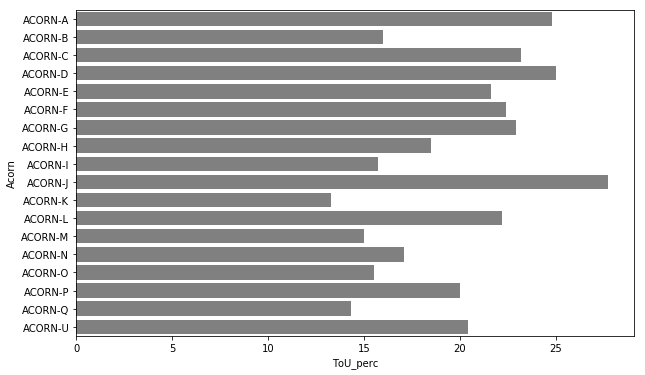

In [8]:
# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x = 'ToU_perc', y = 'Acorn', color='gray', data = counter_type_stats[counter_type_stats['Acorn'] != 'ACORN-'])

### Расчет среднего потребления энергии в зависимости от класса

In [9]:
# Загружаем данные еще раз т.к прошлые были изменены
daily_dataset_with_hh_info = df_daily_dataset.merge(df_informations_households, how = 'left', on = 'LCLid')

In [10]:
# Просмотр минимальных и максимальных дат по каждому классу для того чтобы определить насколько полные данные нам предоставлены
daily_dataset_with_hh_info[ daily_dataset_with_hh_info['energy_count'] == 48][['Acorn', 'day']]\
.groupby(by = 'Acorn')['day'].agg([min, max])

,min,max
Acorn,,
ACORN-,2012-04-18,2014-02-27
ACORN-A,2011-12-04,2014-02-27
ACORN-B,2011-12-24,2014-02-27
ACORN-C,2011-12-07,2014-02-27
ACORN-D,2011-11-24,2014-02-27
ACORN-E,2011-11-24,2014-02-27
ACORN-F,2011-11-24,2014-02-27
ACORN-G,2011-11-24,2014-02-27
ACORN-H,2011-11-25,2014-02-27


In [11]:
# Просмотр кол-ва счетчиков в каждом классе, для оценки предоставленных данных 
daily_dataset_with_hh_info[ daily_dataset_with_hh_info['energy_count'] == 48][['Acorn', 'day']]\
.groupby(by = 'Acorn', as_index=False)['day'].count()

,Acorn,day
0,ACORN-,771
1,ACORN-A,91872
2,ACORN-B,14321
3,ACORN-C,87783
4,ACORN-D,186880
5,ACORN-E,1011407
6,ACORN-F,441804
7,ACORN-G,122381
8,ACORN-H,268989
9,ACORN-I,29120


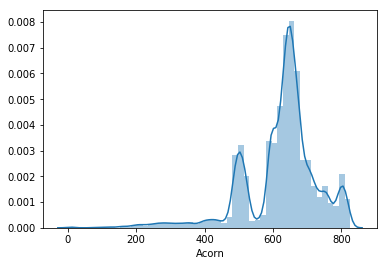

In [12]:
# Смотрим разпределение кол-ва показаний для счетчиков, чтоб понимать, насколько полные данные у нас имеются
df = daily_dataset_with_hh_info[ daily_dataset_with_hh_info['energy_count'] == 48][['LCLid', 'Acorn', 'day']]\
.groupby(by = 'LCLid', as_index=False)['day', 'Acorn'].count()
sns.distplot(df['Acorn'])

# освобождаем память
df = None

#### Расчет результата и строительство графика по классам

In [13]:
# создаем датафрейм, в котором для каждой категории ACORN показан средний расход по разным типам счетчиков
# Исключаем дни с неполными показаниями, менее 48 и неопределенную категорию
counter_type_consumption = daily_dataset_with_hh_info[
    (daily_dataset_with_hh_info['energy_count'] == 48) &
    (daily_dataset_with_hh_info['Acorn'] != 'ACORN-')
].groupby(by = ['Acorn', 'stdorToU'], as_index=False)['energy_sum', 'energy_max'].mean()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

<Figure size 720x720 with 0 Axes>

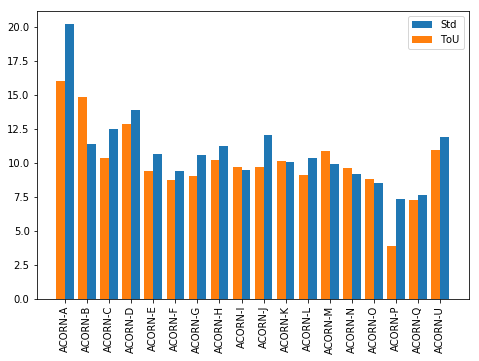

In [15]:
# Строим график для наглядности данных

# Трансформируем таблицу чтобы средние показания счетчиков были разненсены по колонкам
ct = counter_type_consumption.pivot(
    index='Acorn', columns='stdorToU', values='energy_sum'
).reset_index()

# Строим график

# Размер
plt.figure(figsize=(10, 10))
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x = ct['Acorn'], height = ct['Std'], 
         width = 0.4, align = 'edge', label = 'Std')
axes.bar(x = ct['Acorn'], height = ct['ToU'], 
         width = -0.4, align = 'edge', label = 'ToU')
axes.legend(loc = 1)

# Поворот подписей по оси Х
plt.xticks(rotation=90)

#### Расчет общего влияния установки счетчика:

In [16]:
# создаем датафрейм, в котором для каждого типа счетчика показан средний расход
# Исключаем дни с неполными показаниями, менее 48 и неопределенную категорию
report = daily_dataset_with_hh_info[
    (daily_dataset_with_hh_info['energy_count'] == 48) &
    (daily_dataset_with_hh_info['Acorn'] != 'ACORN-')
].groupby(by = 'stdorToU', as_index=False).mean()

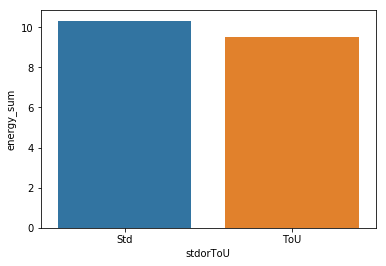

In [17]:
# строим график
sns.barplot(x = 'stdorToU', y = 'energy_sum', data = report)

#### Вычисляем общий процент экономии:

In [18]:
def ToU_percentage(row):
    return round((row['ToU']/((row['Std'] + row['ToU'])/2))*100)-100

def Std_percentage(row):
    return round((row['Std']/((row['Std'] + row['ToU'])/2))*100)-100

# создаем датафрейм, в котором для каждого типа счетчика показан средний расход
# Исключаем дни с неполными показаниями, менее 48 и неопределенную категорию
report = daily_dataset_with_hh_info[
    (daily_dataset_with_hh_info['energy_count'] == 48) &
    (daily_dataset_with_hh_info['Acorn'] != 'ACORN-')
].groupby(by = 'stdorToU')['energy_sum'].mean()

# Делаем из серийного объекта датафрейм и поворачиваем его для удобства
report2 = pd.DataFrame(index = report.index, data={'avg_power':report.values}).T
report2['Std_p'] = report2.apply(Std_percentage, axis=1)
report2['ToU_p'] = report2.apply(ToU_percentage, axis=1)

#### Расчет показывает экономию 4%

In [19]:
report2[['Std_p', 'ToU_p']]

stdorToU,Std_p,ToU_p
avg_power,4.0,-4.0
